# Predicting fire Smoke Impact on Air Quality in Boise, Idaho

This notebook focuses on developing a smoke estimate model and visualizing wildfire data to understand the impact of wildfires on air quality in Boise, Idaho. It utilizes data from `wildfire_geo_proximity.ipynb` and `epa_air_quality_history.ipynb` to build a model that estimates smoke levels based on fire characteristics and distance. The notebook also includes visualizations of fire distance distribution, annual acres burned, and a comparison of estimated smoke levels with actual Air Quality Index (AQI) values.

# Step 1: Prepare data and engineer features for wildfire smoke prediction model.

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [40]:
distance_df = pd.read_csv('/content/drive/MyDrive/DATA 512/Project/intermediate/distance_final.csv')
distance_df.head()

,year,name,size_acres,type,average_distance_miles
0,1961,BIG ANTELOPE (5),55249.740141,Wildfire,374.487188
1,1961,HARLOW (5),43920.841077,Wildfire,472.964683
2,1961,RANCHERIA (5),34233.698603,Wildfire,428.552399
3,1961,BOLLINGER RIDGE (5),32866.053451,Wildfire,519.241975
4,1961,Ditch Creek (3),27269.045936,Wildfire,179.483684


In [41]:
aqi_df = pd.read_csv('/content/drive/MyDrive/DATA 512/Project/intermediate/epa_air_quality_api_response_final.csv')

The section processes air quality data to calculate and clean the average yearly AQI during the fire season, providing a yearly overview of air quality trends.

In [42]:
# Convert 'date_local' column to Pandas datetime objects
aqi_df['date_local'] = pd.to_datetime(aqi_df['date_local'])

# Extract year and month from the 'date_local' column
aqi_df['year'] = aqi_df['date_local'].dt.year
aqi_df['month'] = aqi_df['date_local'].dt.month

# Group by date, month, year, and site number to find the maximum AQI per station per day
daily_max_aqi = aqi_df.groupby(
    ['date_local', 'month', 'year', 'site_number'])['aqi'].max().reset_index()

# Group by date, month, and year to calculate the average AQI per day
daily_avg_aqi = daily_max_aqi.groupby(
    ['date_local', 'month', 'year'])['aqi'].mean().reset_index()

# Group by year to calculate the average AQI during the fire season for each year
yearly_avg_aqi = daily_avg_aqi.groupby('year')['aqi'].mean().reset_index()

# Remove rows with NaN values in the 'aqi' column
yearly_avg_aqi = yearly_avg_aqi[~np.isnan(yearly_avg_aqi['aqi'])]

# Convert the 'year' column to integers
yearly_avg_aqi['year'] = yearly_avg_aqi['year'].astype(int)
yearly_avg_aqi

,year,aqi
1,1975,47.554217
2,1976,70.576087
3,1977,46.961111
4,1978,44.377717
5,1979,52.032609
6,1980,46.652174
7,1981,31.479651
8,1982,45.464481
9,1983,49.657658
10,1984,29.570652


# Step 2. EDA to find coefficient


To identify key factors influencing the smoke estimate model, exploratory data analysis (EDA) was conducted using visualizations. Initial findings revealed a significant correlation between fire type and fire size

## Scatter Plot for Distance vs. Fire Size

Analysis indicates that wildfire type significantly influences fire size, with wildfires generally larger than prescribed fires. This observation informs the weighting scheme used in the prediction model, assigning higher weights to wildfire types associated with larger fire sizes.

In [43]:
distance_df_650 = distance_df[distance_df['average_distance_miles'] <= 650]

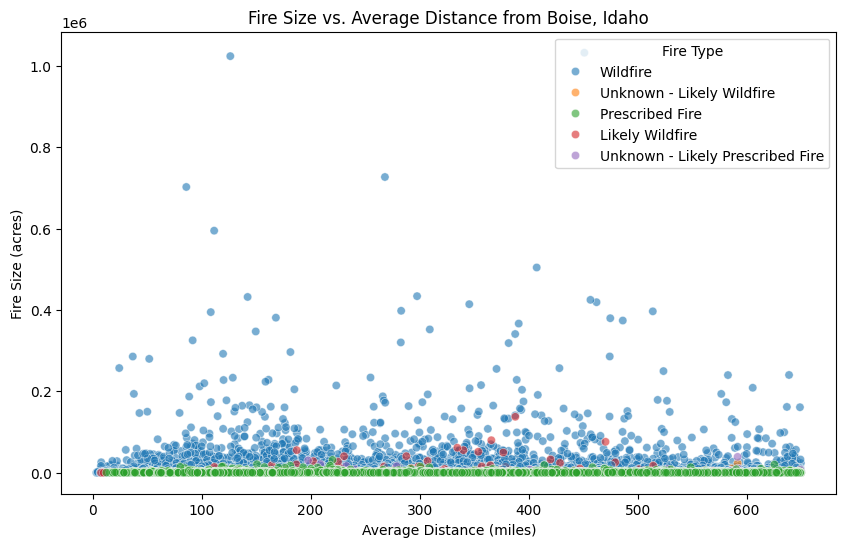

In [44]:
# Scatter Plot for Distance vs. Fire Size
plt.figure(figsize=(10, 6))
sns.scatterplot(data=distance_df_650, x='average_distance_miles', y='size_acres', hue='type', alpha=0.6)
plt.title('Fire Size vs. Average Distance from Boise, Idaho')
plt.xlabel('Average Distance (miles)')
plt.ylabel('Fire Size (acres)')
plt.legend(title='Fire Type')
plt.show()

To analyze the relationship between fire type and size, the categorical 'type' column is one-hot encoded to create numerical features suitable for linear regression.
A scikit-learn LinearRegression model is then fitted to determine the weights associated with each fire type, reflecting their influence on fire size. These weights will be incorporated into the smoke prediction model.

In [45]:
# One-hot encode the 'type' column to convert categorical data to numerical
distance_df_encoded = pd.get_dummies(distance_df_650, columns=['type'], prefix='type')
distance_df_encoded = distance_df_encoded.drop(columns=['name'])

# Define independent variables (X) and dependent variable (y)
X = distance_df_encoded.drop(columns=['size_acres'])
y = distance_df_encoded['size_acres']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Retrieve the model's coefficients
weights = model.coef_

# Create a DataFrame to display features and their weights
weights_df = pd.DataFrame(weights, index=X.columns, columns=['weight'])

# Filter weights_df to include only fire type columns
fire_type_weights_df = weights_df.filter(like='type_', axis=0)

# Find minimum and maximum weights from fire types
min_weight = fire_type_weights_df['weight'].min()
max_weight = fire_type_weights_df['weight'].max()

weights_df.loc[fire_type_weights_df.index, 'normalized_weight'] = (
    (fire_type_weights_df['weight'] - min_weight) / (max_weight - min_weight)
) * 100

# Create a dictionary from fire_type_weights_df mapping fire types to their normalized weights
fire_type_weight_map = weights_df['normalized_weight'].to_dict()

# Map the normalized weights to the distance_df based on fire type
# Remove the 'type_' prefix to match the original fire type names
fire_type_weight_map = {k.replace('type_', ''): v for k, v in fire_type_weight_map.items()}
distance_df['normalized_weight'] = distance_df['type'].map(fire_type_weight_map)

A smoke estimation model is developed using the following formula:

$$ smoke\_estimate = \frac{GIS\_Hectares}{average\_distance\_miles} \times normalized\_weight_{fire\_type} $$

This formula incorporates the normalized weight for fire type, reflecting its influence on smoke production. The resulting smoke estimates are then merged with AQI data for subsequent analysis and comparison to assess the model's accuracy.

In [46]:
# Group by year and mean the size in acres
group_by_df = distance_df.groupby('year')['size_acres'].mean().reset_index()  # Changed to distance_df

# Convert 'size_acres' to 'GIS_Hectares' (1 acre = 0.00404686 square kilometers)
distance_df['GIS_Hectares'] = distance_df['size_acres'] * 0.00404686

# Calculate the smoke estimate using the GIS hectares, closest distance, and normalized weight
distance_df_650 = distance_df[distance_df['average_distance_miles'] <= 650]
distance_df_650['smoke_estimate'] = (distance_df_650['GIS_Hectares'] / distance_df_650['average_distance_miles']) * distance_df_650['normalized_weight']

# Group by year to get the mean of smoke estimate for each year
yearly_smoke_estimate = distance_df_650.groupby('year')['smoke_estimate'].mean().reset_index()  # Changed to distance_df

# Merge the yearly smoke estimate with AQI data on 'year'
merged_df = pd.merge(yearly_smoke_estimate, yearly_avg_aqi, on='year', how='left')

<ipython-input-46-16de4876c210>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  distance_df_650['smoke_estimate'] = (distance_df_650['GIS_Hectares'] / distance_df_650['average_distance_miles']) * distance_df_650['normalized_weight']


Correlation analysis reveals the relationships between the estimated smoke and other factors.
Notably, `size_acres` exhibits a strong positive correlation (0.72), while `average_distance_miles` shows a moderate negative correlation (-0.091).
The `normalized_weight` of fire type also demonstrates a positive correlation (0.059), although weaker than `size_acres`. These correlations suggest that larger fires located closer to Boise, with higher normalized fire type weights, tend to produce more smoke.

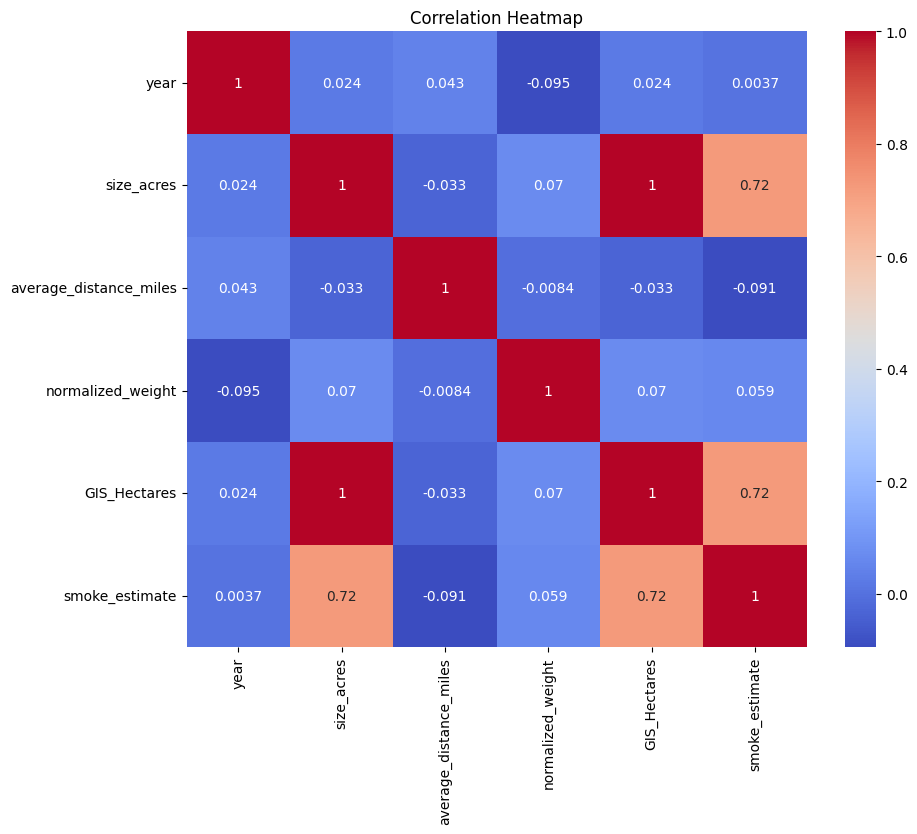

In [47]:
# Select only numeric columns for correlation calculation
numeric_df = distance_df_650.select_dtypes(include=['float64', 'int64'])

# Calculate correlation matrix
correlation_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Step 2: Data Visualization to understand wildfire impacts and model performance.
Visualize wildfire data and model predictions to gain insights into wildfire behavior, smoke estimation accuracy, and their impact on air quality in Boise, Idaho.

## 1. Histogram of Number of Fires by Distance
This histogram illustrates the distribution of wildfires based on their distance from Boise, Idaho, using 1800-mile cutoff.

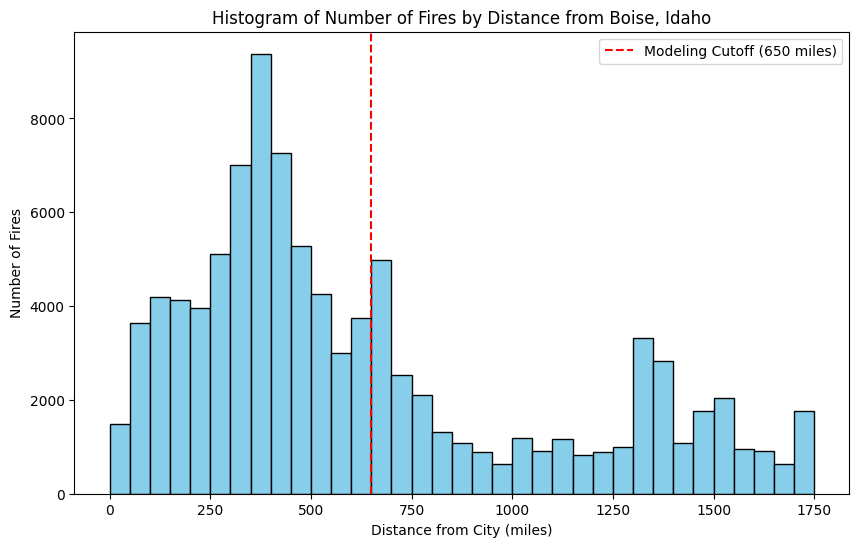

In [48]:
# Create histogram with bins of 50-mile intervals
plt.figure(figsize=(10, 6))
plt.hist(distance_df['average_distance_miles'], bins=range(0, 1800, 50), edgecolor='black', color='skyblue')

# Labeling the axes and title
plt.xlabel('Distance from City (miles)')
plt.ylabel('Number of Fires')
plt.title('Histogram of Number of Fires by Distance from Boise, Idaho')

# Add a vertical line at the 650-mile cutoff
plt.axvline(650, color='red', linestyle='--', linewidth=1.5, label='Modeling Cutoff (650 miles)')

# Add legend and show the plot
plt.legend()
plt.show()


## 2. Time Series of Total Acres Burned per Year

This time series plot displays the trend of total acres burned annually by wildfires within a specified distance from Boise, Idaho, revealing variations in fire activity over the years.

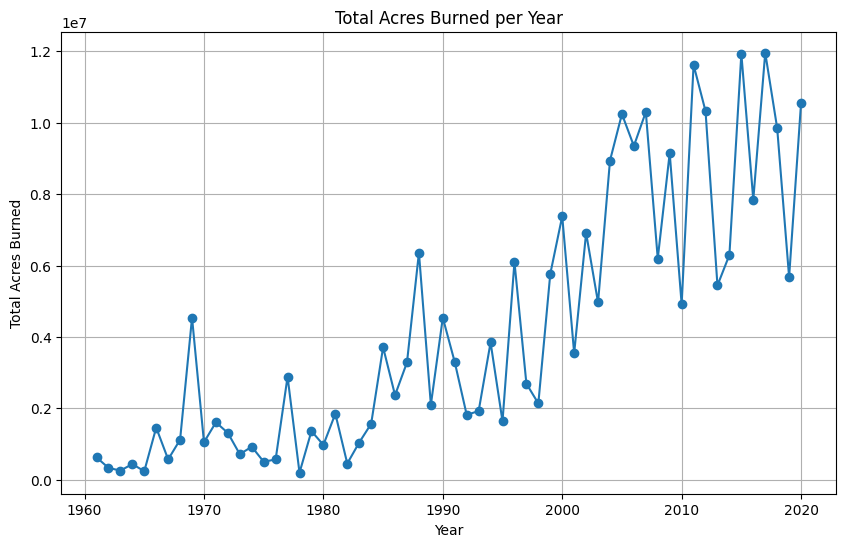

In [49]:
# Group data by year and sum the acres burned
annual_acres_burned = distance_df.groupby('year')['size_acres'].sum().reset_index()

# Plot time series
plt.figure(figsize=(10, 6))
plt.plot(annual_acres_burned['year'], annual_acres_burned['size_acres'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Total Acres Burned')
plt.title('Total Acres Burned per Year')
plt.grid(True)
plt.show()


## 3. Time Series of Fire Smoke Estimates and AQI Estimates

This time series plot compares normalized fire smoke estimates and actual AQI values in Boise, Idaho over time, illustrating the relationship between wildfire activity and air quality.


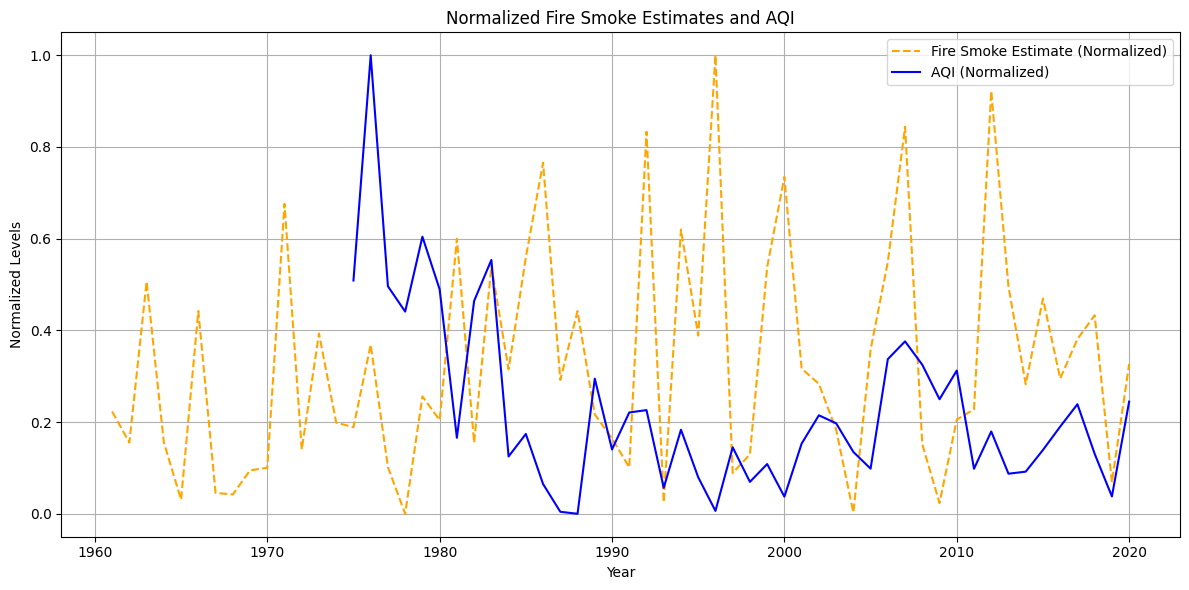

In [50]:
# Set 'year' as index for merged_df
merged_df = merged_df.set_index('year')  # Setting 'year' as index

# Normalize the data (fire_smoke_data and aqi_data)
fire_smoke_data_normalized = (merged_df['smoke_estimate'] - merged_df['smoke_estimate'].min()) / (merged_df['smoke_estimate'].max() - merged_df['smoke_estimate'].min())
aqi_data_normalized = (merged_df['aqi'] - merged_df['aqi'].min()) / (merged_df['aqi'].max() - merged_df['aqi'].min())

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(fire_smoke_data_normalized, label='Fire Smoke Estimate (Normalized)', color='orange', linestyle='--')
plt.plot(aqi_data_normalized, label='AQI (Normalized)', color='blue', linestyle='-')

plt.title("Normalized Fire Smoke Estimates and AQI")
plt.xlabel("Year")
plt.ylabel("Normalized Levels")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()